In [10]:
%pylab inline

%load_ext autoreload
%autoreload 2

import pandas as pd
idx = pd.IndexSlice

from inorg_b import phreeqpy_fns as pf

from tqdm import tqdm

from inorg_b.MyAMI_V3 import MyAMI_K_calc
from cbsyst import Csys, Bsys, non_MyAMI_constants

Populating the interactive namespace from numpy and matplotlib
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
# load raw data
raw_data_url = 'https://docs.google.com/spreadsheets/d/e/2PACX-1vRo_UMyhlIlOpdYffTQMFlySTs8v1lnr1EZpsQBHATWrRBrNJG8CnCnGKJJbcrC6Vj7L9k3_Fy4WmT8/pub?gid=0&single=true&output=csv'
rd = pd.read_csv(raw_data_url, header=[0,1], index_col=[0,1,2])

## Calculate C and B Speciation

In [12]:
def calc_cb_rows(df, dbase='pitzer'):
    """
    Calculate solution conditions for each row of solution data
    """
    # determine column names
    r = df.iloc[0,:]
    cols = pf.calc_cb(temp=r['Temp (°C)'],
                      pH=r['pH (NBS)'],
                      Na=r['[Na] (M)'], 
                      Cl=r['[Cl] (M)'], 
                      Ca=r['[Ca] (M)'], 
                      B=r['[B] (M)'], 
                      DIC=r['[DIC] (M)'], 
                      Mg=r['[Mg] (M)'], dbase=dbase).index

    # create empty output dataframe
    out = pd.DataFrame(index=df.index, columns=cols)
    out.sort_index(1, inplace=True)
    out.sort_index(0, inplace=True)
    
    for i, r in df.iterrows():
        out.loc[i, :] = pf.calc_cb(temp=r['Temp (°C)'],
                                   pH=r['pH (NBS)'],
                                   Na=r['[Na] (M)'], 
                                   Cl=r['[Cl] (M)'], 
                                   Ca=r['[Ca] (M)'], 
                                   B=r['[B] (M)'], 
                                   DIC=r['[DIC] (M)'], 
                                   Mg=r['[Mg] (M)'], dbase=dbase)
    return out

In [13]:
# r = rd.Solution.iloc[0,:]
# dbase = 'minteq.v4'

# pf.calc_cb(temp=r['Temp (°C)'],
#            pH=r['pH (NBS)'],
#            Na=r['[Na] (M)'], 
#            Cl=r['[Cl] (M)'], 
#            Ca=r['[Ca] (M)'], 
#            B=r['[B] (M)'], 
#            DIC=r['[DIC] (M)'], 
#            Mg=r['[Mg] (M)'], dbase=dbase, summ=False)

In [14]:
# empty dataframe for results
calc = pd.DataFrame(index=rd.index, columns=pd.MultiIndex.from_product([[''],['']]))
databases = ['pitzer', 'minteq.v4', 'minteq', 'phreeqc', 'wateq4f']

In [15]:
# phreeqc speciation calcs
for db in tqdm(databases):
    tmp = calc_cb_rows(rd.Solution, dbase=db)
    tmp.columns = pd.MultiIndex.from_product([[db], tmp.columns])
    calc = calc.join(tmp)

100%|██████████| 5/5 [00:04<00:00,  1.16it/s]


In [16]:
MyAMI_K_calc()

{'K0': 0.027605561985725034,
 'K1': 1.1754983606368313e-06,
 'K2': 3.7517320318700845e-10,
 'KB': 1.6262807394012706e-09,
 'KSO4': 0.096013340297122884,
 'KW': 5.4609255153545296e-14,
 'KspA': 2.2101241966747682e-07,
 'KspC': 1.4568283321497974e-07}

In [19]:
# MyAMI speciation calcs, ionic strength method
for i, r in tqdm(rd.Solution.iterrows(), total=rd.shape[0]):
    aSal = 35 * r['ionstr'] / 0.7
    rKs = MyAMI_K_calc(r['Temp (°C)'], aSal, Ca=r['[Ca] (M)'], Mg=r['[Mg] (M)'])
    rKs.update(non_MyAMI_constants.calc_KF(r['Temp (°C)'], aSal))
    rKs.update(non_MyAMI_constants.calc_KPs(r['Temp (°C)'], aSal))
    rKs.update(non_MyAMI_constants.calc_KSi(r['Temp (°C)'], aSal))
    cout = Csys(r['pH (NBS)'], DIC=r['[DIC] (M)'], BT=r['[B] (M)'], TP=0, TSi=0, unit='mol', Ks=rKs)
    bout = Bsys(r['pH (NBS)'], BT=r['[B] (M)'], Ks=rKs)
    
    calc.loc[i, ('MyAMI_eSal', 'B')] = bout.BT
    calc.loc[i, ('MyAMI_eSal', 'BOH3')] = bout.BO3
    calc.loc[i, ('MyAMI_eSal', 'BOH4')] = bout.BO4
    calc.loc[i, ('MyAMI_eSal', 'C')] = cout.DIC
    calc.loc[i, ('MyAMI_eSal', 'CO2')] = cout.CO2
    calc.loc[i, ('MyAMI_eSal', 'HCO3')] = cout.HCO3
    calc.loc[i, ('MyAMI_eSal', 'CO3')] = cout.CO3

  0%|          | 0/59 [00:00<?, ?it/s]/home/oscar/pyenvs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
100%|██████████| 59/59 [00:10<00:00,  5.39it/s]


In [20]:
# MyAMI speciation calcs, full solution comp
for i, r in tqdm(rd.Solution.iterrows(), total=rd.shape[0]):
    aSal = 35 * r['ionstr'] / 0.7
    # in this case, sal must be 35, to stop salinity corrections on gK calculation
    rKs = MyAMI_K_calc(r['Temp (°C)'], 35, Ca=r['[Ca] (M)'], Mg=r['[Mg] (M)'],
                       Na=r['[Na] (M)'], Cl=r['[Cl] (M)'], B=r['[B] (M)'], HSO4=0, SO4=0)
    rKs.update(non_MyAMI_constants.calc_KF(r['Temp (°C)'], aSal))
    rKs.update(non_MyAMI_constants.calc_KPs(r['Temp (°C)'], aSal))
    rKs.update(non_MyAMI_constants.calc_KSi(r['Temp (°C)'], aSal))
    cout = Csys(r['pH (NBS)'], DIC=r['[DIC] (M)'], BT=r['[B] (M)'], TP=0, TSi=0, unit='mol', Ks=rKs)
    bout = Bsys(r['pH (NBS)'], BT=r['[B] (M)'], Ks=rKs)
    
    calc.loc[i, ('MyAMI_full', 'B')] = bout.BT
    calc.loc[i, ('MyAMI_full', 'BOH3')] = bout.BO3
    calc.loc[i, ('MyAMI_full', 'BOH4')] = bout.BO4
    calc.loc[i, ('MyAMI_full', 'C')] = cout.DIC
    calc.loc[i, ('MyAMI_full', 'CO2')] = cout.CO2
    calc.loc[i, ('MyAMI_full', 'HCO3')] = cout.HCO3
    calc.loc[i, ('MyAMI_full', 'CO3')] = cout.CO3

  0%|          | 0/59 [00:00<?, ?it/s]/home/oscar/pyenvs/py3/lib/python3.6/site-packages/ipykernel/kernelbase.py:399: PerformanceWarning: indexing past lexsort depth may impact performance.
  user_expressions, allow_stdin)
100%|██████████| 59/59 [00:16<00:00,  5.92it/s]


In [21]:
calc.sort_index(0, inplace=True)
calc.sort_index(1, inplace=True)

In [22]:
# calc.MyAMI_full.B - (calc.MyAMI_full.BOH3 + calc.MyAMI_full.BOH4)

In [23]:
# calc.MyAMI_full * 1e6

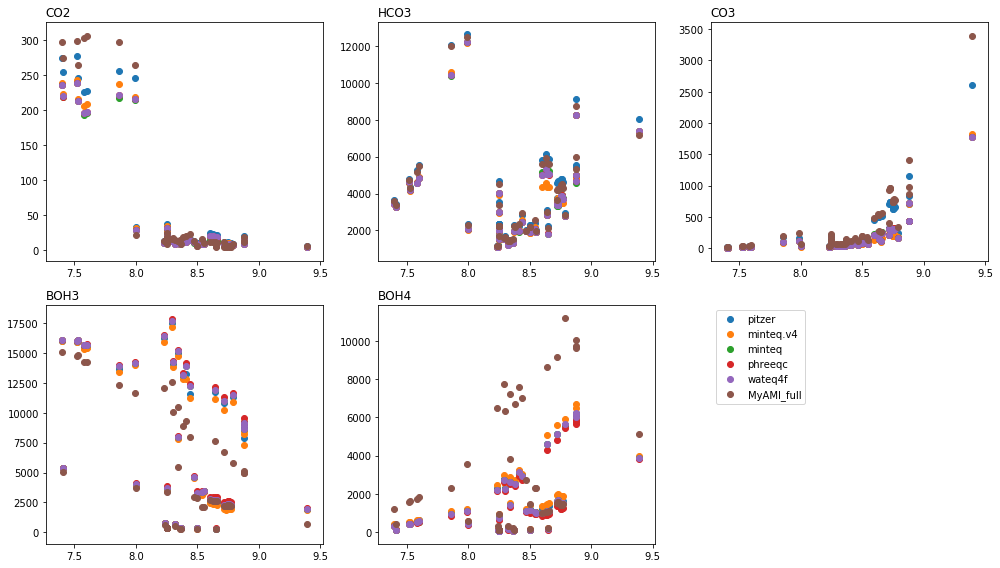

In [24]:
x = 'pH'

fig, axs = plt.subplots(2, 3, figsize=[14,8])

# for db in databases + ['MyAMI_eSal', 'MyAMI_full']:
# for db in ['MyAMI_full', 'pitzer', 'phreeqc', 'wateq4f']:
for db in databases + ['MyAMI_full']:
    axs[0,0].scatter(calc.loc[:, ('pitzer', x)], calc.loc[:, (db, 'CO2')] * 1e6)
    axs[0,1].scatter(calc.loc[:, ('pitzer', x)], calc.loc[:, (db, 'HCO3')] * 1e6)
    axs[0,2].scatter(calc.loc[:, ('pitzer', x)], calc.loc[:, (db, 'CO3')] * 1e6)
    
    axs[1,0].scatter(calc.loc[:, ('pitzer', x)], calc.loc[:, (db, 'BOH3')] * 1e6)
    axs[1,1].scatter(calc.loc[:, ('pitzer', x)], calc.loc[:, (db, 'BOH4')] * 1e6)
    
    axs[1,2].scatter([], [], label=db)

axs[0,0].set_title('CO2', loc='left')
axs[0,1].set_title('HCO3', loc='left')
axs[0,2].set_title('CO3', loc='left')
axs[1,0].set_title('BOH3', loc='left')
axs[1,1].set_title('BOH4', loc='left')

axs[1,2].axis('off')
axs[1,2].legend(loc='upper left')

fig.tight_layout()

In [25]:
rd.sort_index(inplace=True)
idx = pd.IndexSlice

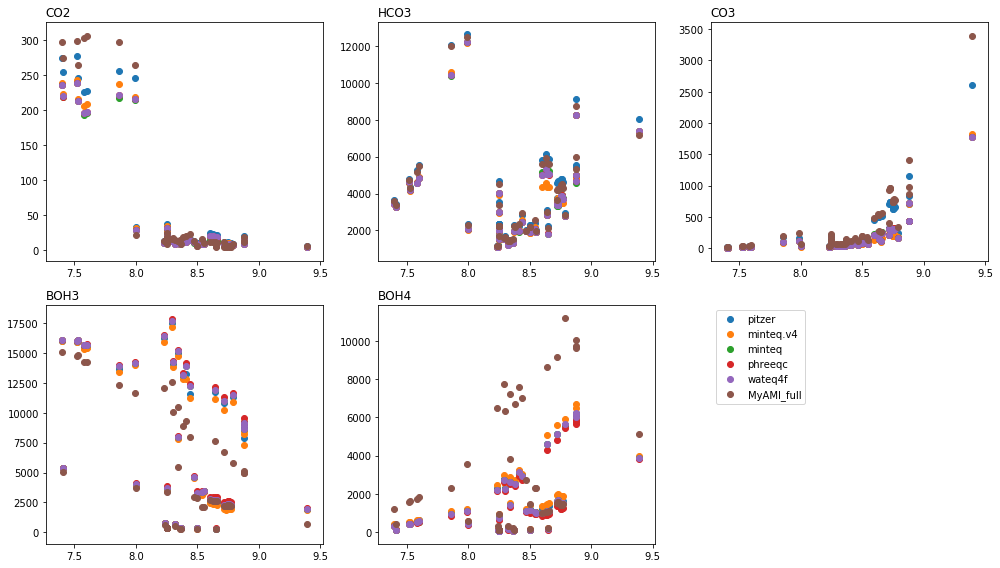

In [26]:
x = 'pH'

# sub = calc.loc[idx[:, 'Noireaux', :], :]
sub = calc

fig, axs = plt.subplots(2, 3, figsize=[14,8])

# for db in databases + ['MyAMI_eSal', 'MyAMI_full']:
# for db in ['MyAMI_full', 'pitzer', 'phreeqc', 'wateq4f']:
for db in databases + ['MyAMI_full']:
    axs[0,0].scatter(sub.loc[:, ('pitzer', x)], sub.loc[:, (db, 'CO2')] * 1e6)
    axs[0,1].scatter(sub.loc[:, ('pitzer', x)], sub.loc[:, (db, 'HCO3')] * 1e6)
    axs[0,2].scatter(sub.loc[:, ('pitzer', x)], sub.loc[:, (db, 'CO3')] * 1e6)
    
    axs[1,0].scatter(sub.loc[:, ('pitzer', x)], sub.loc[:, (db, 'BOH3')] * 1e6)
    axs[1,1].scatter(sub.loc[:, ('pitzer', x)], sub.loc[:, (db, 'BOH4')] * 1e6)
    
    axs[1,2].scatter([], [], label=db)

axs[0,0].set_title('CO2', loc='left')
axs[0,1].set_title('HCO3', loc='left')
axs[0,2].set_title('CO3', loc='left')
axs[1,0].set_title('BOH3', loc='left')
axs[1,1].set_title('BOH4', loc='left')

axs[1,2].axis('off')
axs[1,2].legend(loc='upper left')

fig.tight_layout()

## MyAMI vs Pitzer

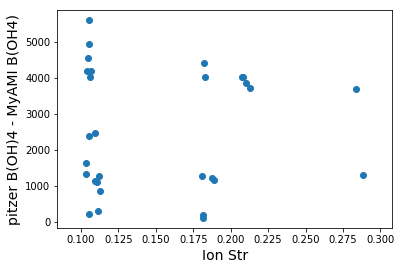

In [27]:
# sub = calc
sub = calc.loc[idx[:, 'Noireaux', :], :]

plt.scatter(sub.loc[:, ('pitzer', 'ion_str')],
            (sub.loc[:, ('MyAMI_full', 'BOH4')] - sub.loc[:, ('pitzer', 'BOH4')]) * 1e6)
#             c=calc.loc[:, ('pitzer', 'pH')])
plt.xlabel('Ion Str', fontsize=14)
plt.ylabel('pitzer B(OH)4 - MyAMI B(OH4)', fontsize=14)

## KB

In [28]:
# Dickson ionic strength vs pKB

ion_str = [0.1,0.3,0.5,1]
pKB = [9.016,8.939,8.907,8.899]

ion_str_2 = [0.1, 0.3, 0.5, 0.7, 0.9] 
pKB_2 = [8.921, 8.751, 8.656, 8.580, 8.530]

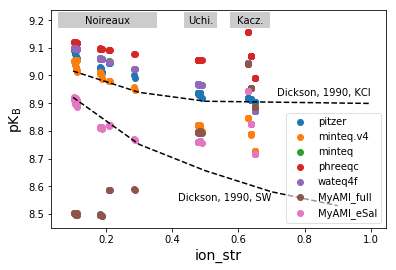

In [29]:
# sub = calc.loc[idx[:, 'Uchikawa', :], :]
sub = calc

x = 'ion_str'

for db in databases + ['MyAMI_full', 'MyAMI_eSal']:
    plt.scatter(sub.loc[:, ('pitzer', x)], 
                -np.log10((10**-sub.loc[:, ('pitzer', 'pH')] * 
                           sub.loc[:, (db, 'BOH4')] / 
                           sub.loc[:, (db, 'BOH3')]).astype(float)),
                label=db)
plt.xlabel(x, fontsize=14)
plt.ylabel('$pK_B$', fontsize=14)
plt.legend(framealpha=0.6, loc='lower right')

plt.plot(ion_str, pKB, c='k', ls='dashed')
plt.plot(ion_str_2, pKB_2, c='k', ls='dashed')

plt.text(1, 8.92, 'Dickson, 1990, KCl', ha='right', va='bottom')
plt.text(0.7, 8.54, 'Dickson, 1990, SW', ha='right', va='bottom')

lohi = (.08, .33)
plt.plot(lohi, [9.2, 9.2], lw=16, c=(0,0,0,0.2))
plt.text(np.mean(lohi), 9.2, 'Noireaux', va='center', ha='center', fontsize=10)

lohi = (.46, .51)
plt.plot(lohi, [9.2, 9.2], lw=16, c=(0,0,0,0.2))
plt.text(np.mean(lohi), 9.2, 'Uchi.', va='center', ha='center', fontsize=10)

lohi = (.6, .67)
plt.plot(lohi, [9.2, 9.2], lw=16, c=(0,0,0,0.2))
plt.text(np.mean(lohi), 9.2, 'Kacz.', va='center', ha='center', fontsize=10)

MyAMI doesn't work well for simple (non-seawater) solutions, and can't be modified easily to do so.

## Ion-Paired C species

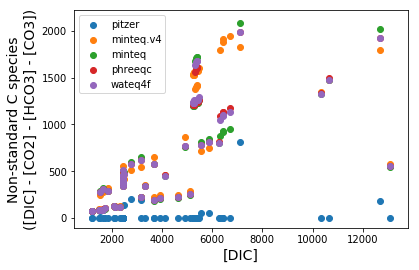

In [30]:
for db in databases:
    plt.scatter(calc.loc[:, (db, 'C')] * 1e6, 
                (calc.loc[:, (db, 'C')] - calc.loc[:, (db, 'CO2')] - calc.loc[:, (db, 'HCO3')] - calc.loc[:, (db, 'CO3')]) * 1e6,
                label=db)
plt.xlabel('[DIC]', fontsize=14)
plt.ylabel('Non-standard C species\n([DIC] - [CO2] - [HCO3] - [CO3])', fontsize=14)
plt.legend()

## pKB veracity

In [31]:
pkbs = pd.read_excel('pKb-measurements.xlsx')
pkbs.replace(np.nan, 0, inplace=True)
pkbs.set_index(['reference', 'solution'], inplace=True)

pkbs.columns = pd.MultiIndex.from_product([['orig'],pkbs.columns])
pkbs.sort_index(inplace=True)

In [32]:
databases = ['pitzer', 'minteq.v4', 'minteq', 'phreeqc', 'wateq4f']

In [33]:
# pkcalc = pd.DataFrame(index=pkbs.index, columns=pd.MultiIndex.from_product([[''],['']]))
# databases = ['pitzer', 'minteq.v4', 'minteq', 'phreeqc', 'wateq4f']
# cols = pf.calc_cb().index.values
pkcalc = []
for db in databases:
    dbsub = []
    for i, r in pkbs.orig.iterrows():
        out = pf.calc_cb(temp=r['T (°C)'],
                         pH=r['pH'],
                         Na=r['[Na] (m)'], 
                         Cl=r['[Cl] (m)'], 
                         K=r['[K] (m)'],
                         B=r['[B] (m)'],
                         Ca=r['[Ca] (m)'],
                         DIC=0,
                         Mg=r['[Mg] (m)'],
                         SO4=r['[SO4] (m)'],
                         dbase=db)
        out.name = i
        dbsub.append(out)
    dbsub = pd.concat(dbsub, 1).T
    dbsub.loc[:, 'pKB_free'] = -np.log10(10**-dbsub.loc[:, 'pH'] * dbsub.loc[:, 'BOH4_free'] / dbsub.loc[:, 'BOH3'])
    dbsub.loc[:, 'pKB'] = -np.log10(10**-dbsub.loc[:, 'pH'] * dbsub.loc[:, 'BOH4'] / dbsub.loc[:, 'BOH3'])
    dbsub.columns = pd.MultiIndex.from_product([[db], dbsub.columns])
    pkcalc.append(dbsub)

pkcalc = pd.concat(pkcalc, 1)

pkbs = pd.concat([pkcalc, pkbs], 1)

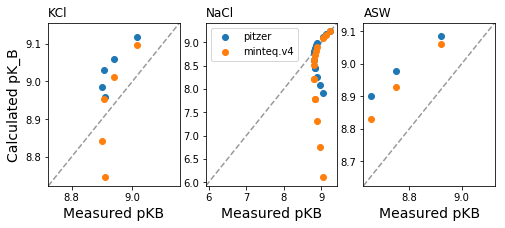

In [34]:
fig, axs = plt.subplots(1, 3, figsize=[8, 3])

x = 'pKB'
dbs = ['pitzer', 'minteq.v4']

for sol, ax in zip(['KCl', 'NaCl', 'ASW'], axs):
    sub = pkbs.loc[idx[:, sol] ,:]
    ax.set_title(sol, loc='left')
    for db in dbs:
        ax.scatter(sub.loc[:, ('orig', x)].values, sub.loc[:, (db, 'pKB')].values, label=db)
    ax.set_xlabel('Measured ' + x, fontsize=14)

axs[1].legend()
axs[0].set_ylabel('Calculated pK_B', fontsize=14)

for ax in axs:
    lims = ax.get_ylim()
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, c='k', ls='dashed', zorder=-1, alpha=0.4)

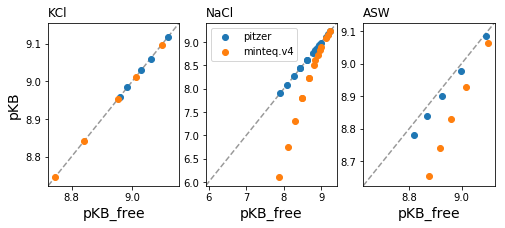

In [35]:
fig, axs = plt.subplots(1, 3, figsize=[8, 3])

x = 'pKB'
dbs = ['pitzer', 'minteq.v4']

for sol, ax in zip(['KCl', 'NaCl', 'ASW'], axs):
    sub = pkbs.loc[idx[:, sol] ,:]
    ax.set_title(sol, loc='left')
    for db in dbs:
        ax.scatter(sub.loc[:, (db, 'pKB_free')].values, sub.loc[:, (db, 'pKB')].values, label=db)
    ax.set_xlabel('pKB_free', fontsize=14)

axs[1].legend()
axs[0].set_ylabel('pKB', fontsize=14)

for ax in axs:
    lims = ax.get_ylim()
    ax.set_xlim(lims)
    ax.set_ylim(lims)
    ax.plot(lims, lims, c='k', ls='dashed', zorder=-1, alpha=0.4)

In [36]:
pkbs['orig'].columns

Index(['pH', 'T (°C)', '[Na] (m)', '[K] (m)', '[Mg] (m)', '[Ca] (m)',
       '[Cl] (m)', '[SO4] (m)', '[B] (m)', 'Ion. Str. (I)', 'Salinity', 'pKB',
       'pKB_meas'],
      dtype='object')

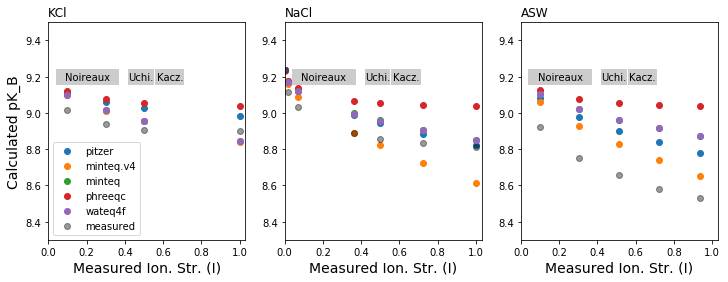

In [37]:
fig, axs = plt.subplots(1, 3, figsize=[12, 4])

x = 'Ion. Str. (I)'
xm = 1
# dbs = ['pitzer', 'minteq.v4']
dbs = databases

for sol, ax in zip(['KCl', 'NaCl', 'ASW'], axs):
    sub = pkbs.loc[idx[:, sol] ,:]
    ax.set_title(sol, loc='left')
    for db in dbs:
        ax.scatter(sub.loc[:, ('orig', x)].values * xm, sub.loc[:, (db, 'pKB')].values, label=db)
    ax.set_xlabel('Measured ' + x, fontsize=14)
    
    ax.scatter(sub.loc[:, ('orig', x)].values * xm,
               sub.loc[:, ('orig', 'pKB')].values,
               c='k', alpha=0.4, label='measured')

axs[0].legend()
axs[0].set_ylabel('Calculated pK_B', fontsize=14)


for ax in axs:
    ax.set_xlim(0, 1.03)
    ax.set_ylim(8.3, 9.5)
#     lims = ax.get_ylim()
#     ax.set_xlim(lims)
#     ax.set_ylim(lims)
#     ax.plot(lims, lims, c='k', ls='dashed', zorder=-1, alpha=0.4)

for ax in axs:
    y = 9.2
    lohi = (.08, .33)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Noireaux', va='center', ha='center', fontsize=10)

    lohi = (.46, .51)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Uchi.', va='center', ha='center', fontsize=10)

    lohi = (.6, .67)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Kacz.', va='center', ha='center', fontsize=10)

In [38]:
pts.get_facecolor()

NameError: name 'pts' is not defined

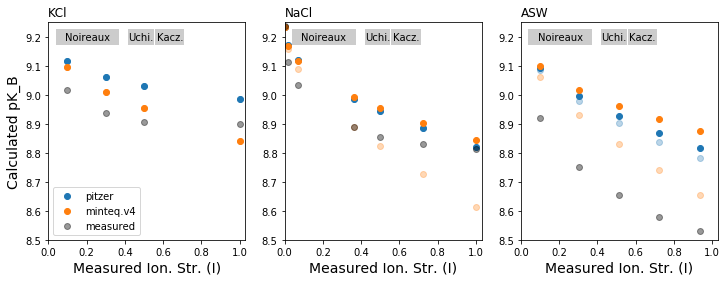

In [39]:
fig, axs = plt.subplots(1, 3, figsize=[12, 4])

x = 'Ion. Str. (I)'
xm = 1
dbs = ['pitzer', 'minteq.v4']
# dbs = databases

for sol, ax in zip(['KCl', 'NaCl', 'ASW'], axs):
    sub = pkbs.loc[idx[:, sol] ,:]
    ax.set_title(sol, loc='left')
    for db in dbs:
        pts = ax.scatter(sub.loc[:, ('orig', x)].values * xm, sub.loc[:, (db, 'pKB')].values, alpha=0.3)
        c = pts.get_facecolor().copy()
        c[0][-1] = 1
        ax.scatter(sub.loc[:, ('orig', x)].values * xm, sub.loc[:, (db, 'pKB_free')].values, label=db, c=c)
    ax.set_xlabel('Measured ' + x, fontsize=14)
    
    ax.scatter(sub.loc[:, ('orig', x)].values * xm,
               sub.loc[:, ('orig', 'pKB')].values,
               c='k', alpha=0.4, label='measured')

axs[0].legend()
axs[0].set_ylabel('Calculated pK_B', fontsize=14)


for ax in axs:
    ax.set_xlim(0, 1.03)
    ax.set_ylim(8.5, 9.25)
#     lims = ax.get_ylim()
#     ax.set_xlim(lims)
#     ax.set_ylim(lims)
#     ax.plot(lims, lims, c='k', ls='dashed', zorder=-1, alpha=0.4)

for ax in axs:
    y = 9.2
    lohi = (.08, .33)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Noireaux', va='center', ha='center', fontsize=10)

    lohi = (.46, .51)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Uchi.', va='center', ha='center', fontsize=10)

    lohi = (.6, .67)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Kacz.', va='center', ha='center', fontsize=10)

### Include MyAMI

In [40]:
# exclude Hershed (ionic str range not useful)
pkbs = pkbs.iloc[pkbs.index.get_level_values(0) != 'Hershey (1986) GCA']

In [48]:
# in ASW
tmp = []
for i, r in pkbs.loc[idx[:,'ASW'],:].orig.iterrows():
    Ks = MyAMI_K_calc(TempC=r['T (°C)'],
                      Sal=r['Salinity'],
                      Na=r['[Na] (m)'], 
                      Cl=r['[Cl] (m)'], 
                      K=r['[K] (m)'],
                      B=r['[B] (m)'],
                      Ca=r['[Ca] (m)'],
                      HCO3=0, CO3=0,
                      Mg=r['[Mg] (m)'],
                      SO4=r['[SO4] (m)'])
    tmp.append(-np.log10(Ks.KB))

pkbs.loc[i, ('MyAMI_full', 'pKB')] = tmp

In [49]:
# In NaCl
tmp = []
for i, r in pkbs.loc[idx[:,'NaCl'],:].orig.iterrows():
    Ks = MyAMI_K_calc(TempC=r['T (°C)'],
                      Sal=r['Salinity'],
                      Na=r['[Na] (m)'], 
                      Cl=r['[Cl] (m)'], 
                      K=r['[K] (m)'],
                      B=r['[B] (m)'],
                      Ca=r['[Ca] (m)'],
                      HCO3=0, CO3=0,
                      Mg=r['[Mg] (m)'],
                      SO4=r['[SO4] (m)'])
    tmp.append(-np.log10(Ks.KB))
    
pkbs.loc[i, ('MyAMI_full', 'pKB')] = tmp

/home/oscar/GoogleDrive/MyPapers/_InProgress/Inorganic_B/Data/Supplement/inorg_b/MyAMI_V3.py:1355: RuntimeWarning: overflow encountered in exp
  k / TempK * Istr * Istr + np.log(1 - 0.001005 * Sal))
/home/oscar/GoogleDrive/MyPapers/_InProgress/Inorganic_B/Data/Supplement/inorg_b/MyAMI_V3.py:1371: RuntimeWarning: overflow encountered in power
  i * Sal**1.5))


In [50]:
# In KCl
tmp = []
for i, r in pkbs.loc[idx[:,'KCl'],:].orig.iterrows():
    Ks = MyAMI_K_calc(TempC=r['T (°C)'],
                      Sal=r['Salinity'],
                      Na=r['[Na] (m)'], 
                      Cl=r['[Cl] (m)'], 
                      K=r['[K] (m)'],
                      B=r['[B] (m)'],
                      Ca=r['[Ca] (m)'],
                      HCO3=0, CO3=0,
                      Mg=r['[Mg] (m)'],
                      SO4=r['[SO4] (m)'])
    tmp.append(-np.log10(Ks.KB))
    
pkbs.loc[i, ('MyAMI_full', 'pKB')] = tmp

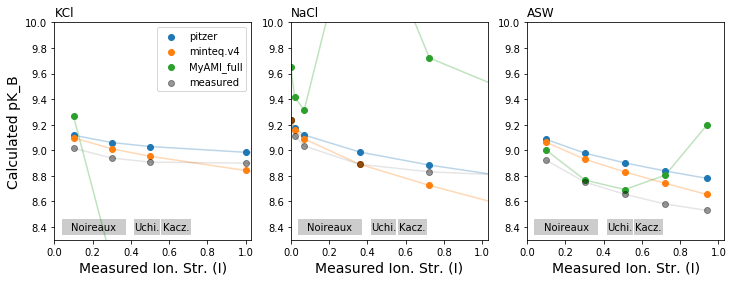

In [53]:
fig, axs = plt.subplots(1, 3, figsize=[12, 4])

x = 'Ion. Str. (I)'
xm = 1
dbs = ['pitzer', 'minteq.v4', 'MyAMI_full']
# dbs = databases

for sol, ax in zip(['KCl', 'NaCl', 'ASW'], axs):
    sub = pkbs.loc[idx[:, sol] ,:]
    ax.set_title(sol, loc='left')
    for db in dbs:
        ax.scatter(sub.loc[:, ('orig', x)].values * xm, sub.loc[:, (db, 'pKB')].values, label=db)
        ax.plot(sub.loc[:, ('orig', x)].values * xm, sub.loc[:, (db, 'pKB')].values, zorder=-1, alpha=0.3)
    ax.set_xlabel('Measured ' + x, fontsize=14)
    
    ax.scatter(sub.loc[:, ('orig', x)].values * xm,
               sub.loc[:, ('orig', 'pKB')].values,
               c='k', alpha=0.4, label='measured')
    ax.plot(sub.loc[:, ('orig', x)].values * xm,
            sub.loc[:, ('orig', 'pKB')].values,
            c='k', alpha=0.1, zorder=-1)

axs[0].legend()
axs[0].set_ylabel('Calculated pK_B', fontsize=14)


for ax in axs:
    ax.set_xlim(0, 1.03)
    ax.set_ylim(8.3, 10)
#     lims = ax.get_ylim()
#     ax.set_xlim(lims)
#     ax.set_ylim(lims)
#     ax.plot(lims, lims, c='k', ls='dashed', zorder=-1, alpha=0.4)

for ax in axs:
    y = 8.4
    lohi = (.08, .33)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Noireaux', va='center', ha='center', fontsize=10)

    lohi = (.46, .51)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Uchi.', va='center', ha='center', fontsize=10)

    lohi = (.6, .67)
    ax.plot(lohi, [y, y], lw=16, c=(0,0,0,0.2))
    ax.text(np.mean(lohi), y, 'Kacz.', va='center', ha='center', fontsize=10)

fig.savefig('../../Figures/pKB_comparison.pdf')

In [43]:
-np.log10(MyAMI_K_calc(25, 25).KB)

8.7300906823927455